In [1]:
image_indexx = [1]


In [2]:
import albumentations as A
import cv2
from glob import glob
import os
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from dataset_cityscapes import *
from epoch import *
import neptune
import pickle
from segmentation_models_pytorch import Unet
import torch
import argparse
import os
import cv2
from segmentation_models_pytorch import Unet
from skimage.io import imread,imsave
import numpy as np
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import imageio

from utils import *
# from color_map import cm_data
from rasterio.features import shapes
from tqdm.notebook import tqdm

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype("float32")


# ======== CONFIGURATION ======== #
S_NAME_ENCODER = "efficientnet-b4"
S_NAME_WEIGHTS = "imagenet"
P_DIR_MODEL_NOISE = "/home/jamada/jupyterlab/eo-xai/whu_noise_training/UNET_EfficientNetB4_CE/Checkpoints-479/model_epoch_0030.pth"

# S_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "CPU")
S_DEVICE = 'cpu'
P_DIR_MODEL_UTIL ="/home/jamada/UrbanModels/weights_pytorch/tu-tf_efficientnet_b0_Unet_whu_3-classes_40-epochs_TRY001"

# ======== UTILITY ======== #
model = Unet(
        encoder_name = "tu-tf_efficientnet_b0",
        encoder_depth= 5,
        encoder_weights = None,
        decoder_use_batchnorm = True,
        decoder_channels = (256, 128, 64, 32, 16),
        decoder_attention_type = None,
        in_channels= 3,
        classes = 3,
        activation = 'sigmoid',
        aux_params = None,
    )

utility_model = load_model(model,P_DIR_MODEL_UTIL)

# ======== SETUP ======== #
# setup model
noise_model = torch.load(P_DIR_MODEL_NOISE, map_location=S_DEVICE)  
noise_model.eval()

# setup input normalization
preprocess_input = get_preprocessing_fn(
    encoder_name = S_NAME_ENCODER,
    pretrained = S_NAME_WEIGHTS,
)

transform_full = A.Compose([
    A.Lambda(name = "to_tensor", image = to_tensor),
])

# setup datasets
dataset_test = DataLoaderSegmentation(
    image_path = "/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/A",
    mask_path = "/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/OUT",
    transform = transform_full,
    device = S_DEVICE
)




/home/jamada/jupyterlab/eo-xai/xai_fyp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


length of images:  4736
length of masks:  4736


In [3]:
"""
Created on Saturday, August 20, 2022
Updated on Wednesday, June, 14, 2023
@author: Abdul Karim GIZZINI
"""
from PIL import Image
import numpy as np
import ttach as tta
import torch
import warnings
from skimage.io import imread
import matplotlib.pyplot as plt
from segmentation_models_pytorch import Unet
import argparse
import os
from typing import Callable, List
import cv2
import tqdm
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from skimage.segmentation import watershed
from skimage.measure import label
from pytorch_grad_cam.utils.svd_on_activations import get_2d_projection
from pytorch_grad_cam.utils.image import scale_cam_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


# Grad-Cam Classes
class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients
            # self.gradients = [torch.mul(t, -1) for t in self.gradients]

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()


class GRADCAMEXTENDED:
    def __init__(self, model: torch.nn.Module, target_layers: List[torch.nn.Module], use_cuda: bool = False,
                 reshape_transform: Callable = None, compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(self.model, target_layers, reshape_transform)

    def forward(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        # print('\n----------------------------------------Seg-Grad-Cam----------------------------------------------------\n')

        if self.cuda:
            input_tensor = input_tensor.cuda()
        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor, requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        activations_list = [a.cpu().data.numpy() for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy() for g in self.activations_and_grads.gradients]
        target_size = input_tensor.size(-1), input_tensor.size(-2)
        # print('Activations list size: ', len(activations_list))
        # print('Gradients list size: ', len(grads_list))
        # print('Target layer size: ', len(self.target_layers))

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            # print('\t\t\t-----------------------\n')
            # print('Target Layer ', i + 1, ': ', target_layer)
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]

            # layer_grads = - layer_grads
            weights = np.mean(layer_grads, axis=(2, 3))
            weighs_up = weights[:, :, None, None] 
            # print('weights updated: ', weighs_up.shape)
            weighted_activations = weights[:, :, None, None] * layer_activations
            # print('Activations per layer size: ', layer_activations.shape)
            # print('Gradients per layer size: ', layer_grads.shape)
            # print('Weights per layer size: ', weights.shape)
            # print("Weights  x activation: ", weighted_activations.shape)
            if eigen_smooth:
                cam = get_2d_projection(weighted_activations)
                print("Cam image per layer size: ", cam.shape)
            else:
                cam = weighted_activations.sum(axis=1)
                # print("Cam image per layer size: ", cam.shape)

            cam = np.maximum(cam, 0)
            # print("Cam image  Max per layer size: ", cam.shape)
            scaled = scale_cam_image(cam, target_size)
            # print("Scaled Cam image per layer size: ", scaled.shape)
            cam_per_target_layer.append(scaled[:, None, :])

        # print("Cam image list size: ", len(cam_per_target_layer))
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        # print("Cam image list Concat size: ", len(cam_per_target_layer))
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        # print("Cam image list (max) size: ", len(cam_per_target_layer))
        result = np.mean(cam_per_target_layer, axis=1)
        # print("+++ Averaged CAM list size: ", result.shape)

        
        return scale_cam_image(result) # result

    def __call__(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module] = None, aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:
        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            transforms = tta.Compose(
                [
                    tta.HorizontalFlip(),
                    tta.Multiply(factors=[0.9, 1, 1.1]),
                ]
            )
            cams = []
            for transform in transforms:
                augmented_tensor = transform.augment_image(input_tensor)
                cam = self.forward(augmented_tensor, targets, eigen_smooth)
                # The ttach library expects a tensor of size BxCxHxW
                cam = cam[:, None, :, :]
                cam = torch.from_numpy(cam)
                cam = transform.deaugment_mask(cam)
                # Back to numpy float32, HxW
                cam = cam.numpy()
                cam = cam[:, 0, :, :]
                cams.append(cam)
            cam = np.mean(np.float32(cams), axis=0)
            return cam
        else:
            return self.forward(input_tensor, targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True



class GRADCAMEXTENDED_Plusplus:
    def __init__(self, model: torch.nn.Module, target_layers: List[torch.nn.Module], use_cuda: bool = False,
                 reshape_transform: Callable = None, compute_input_gradient: bool = False,
                 uses_gradients: bool = True) -> None:
        self.model = model.eval()
        self.target_layers = target_layers
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.reshape_transform = reshape_transform
        self.compute_input_gradient = compute_input_gradient
        self.uses_gradients = uses_gradients
        self.activations_and_grads = ActivationsAndGradients(self.model, target_layers, reshape_transform)

    def forward(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module],
                eigen_smooth: bool = False) -> np.ndarray:

        # print(
        #     '\n----------------------------------------Seg-Grad-Cam ++ ----------------------------------------------------\n')

        if self.cuda:
            input_tensor = input_tensor.cuda()
        if self.compute_input_gradient:
            input_tensor = torch.autograd.Variable(input_tensor, requires_grad=True)

        outputs = self.activations_and_grads(input_tensor)
        if targets is None:
            target_categories = np.argmax(outputs.cpu().data.numpy(), axis=-1)
            targets = [ClassifierOutputTarget(category) for category in target_categories]

        if self.uses_gradients:
            self.model.zero_grad()
            loss = sum([target(output) for target, output in zip(targets, outputs)])
            loss.backward(retain_graph=True)

        activations_list = [a.cpu().data.numpy() for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy() for g in self.activations_and_grads.gradients]
        target_size = input_tensor.size(-1), input_tensor.size(-2)
        # print('Activations list size: ', len(activations_list))
        # print('Gradients list size: ', len(grads_list))
        # print('Target layer size: ', len(self.target_layers))

        cam_per_target_layer = []
        # Loop over the saliency image from every layer
        for i in range(len(self.target_layers)):
            target_layer = self.target_layers[i]
            # print('\t\t\t-----------------------\n')
            # print('Target Layer ', i + 1, ': ', target_layer)
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]


            grads_power_2 = layer_grads**2
            grads_power_3 = grads_power_2 * layer_grads
            # Equation 19 in https://arxiv.org/abs/1710.11063
            sum_activations = np.sum(layer_activations, axis=(2, 3))
            eps = 0.000001
            aij = grads_power_2 / (2 * grads_power_2 +
                               sum_activations[:, :, None, None] * grads_power_3 + eps)
            # Now bring back the ReLU from eq.7 in the paper,
            # And zero out aijs where the activations are 0
            aij = np.where(layer_grads != 0, aij, 0)

            weights = np.maximum(layer_grads, 0) * aij
            weights = np.sum(weights, axis=(2, 3))
            # print('weights updated: ', weighs_up.shape)
            weighted_activations = weights[:, :, None, None] * layer_activations
            # print('Activations per layer size: ', layer_activations.shape)
            # print('Gradients per layer size: ', layer_grads.shape)
            # print('Weights per layer size: ', weights.shape)
            # print("Weights  x activation: ", weighted_activations.shape)
            if eigen_smooth:
                cam = get_2d_projection(weighted_activations)
                print("Cam image per layer size: ", cam.shape)
            else:
                cam = weighted_activations.sum(axis=1)
                # print("Cam image per layer size: ", cam.shape)

            cam = np.maximum(cam, 0)
            # print("Cam image  Max per layer size: ", cam.shape)
            scaled = scale_cam_image(cam, target_size)
            # print("Scaled Cam image per layer size: ", scaled.shape)
            cam_per_target_layer.append(scaled[:, None, :])

        # print("Cam image list size: ", len(cam_per_target_layer))
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        # print("Cam image list Concat size: ", len(cam_per_target_layer))
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        # print("Cam image list (max) size: ", len(cam_per_target_layer))
        result = np.mean(cam_per_target_layer, axis=1)
        # print("+++ Averaged CAM list size: ", result.shape)

        
        return scale_cam_image(result) # result

    def __call__(self, input_tensor: torch.Tensor, targets: List[torch.nn.Module] = None, aug_smooth: bool = False,
                 eigen_smooth: bool = False) -> np.ndarray:
        # Smooth the CAM result with test time augmentation
        if aug_smooth is True:
            transforms = tta.Compose(
                [
                    tta.HorizontalFlip(),
                    tta.Multiply(factors=[0.9, 1, 1.1]),
                ]
            )
            cams = []
            for transform in transforms:
                augmented_tensor = transform.augment_image(input_tensor)
                cam = self.forward(augmented_tensor, targets, eigen_smooth)
                # The ttach library expects a tensor of size BxCxHxW
                cam = cam[:, None, :, :]
                cam = torch.from_numpy(cam)
                cam = transform.deaugment_mask(cam)
                # Back to numpy float32, HxW
                cam = cam.numpy()
                cam = cam[:, 0, :, :]
                cams.append(cam)
            cam = np.mean(np.float32(cams), axis=0)
            return cam
        else:
            return self.forward(input_tensor, targets, eigen_smooth)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True






XAI Methods for Target Class:  road ... 


Testing Image:  0
/home/jamada/jupyterlab/datasets/WHU/WHU_building/train/A/1048.png


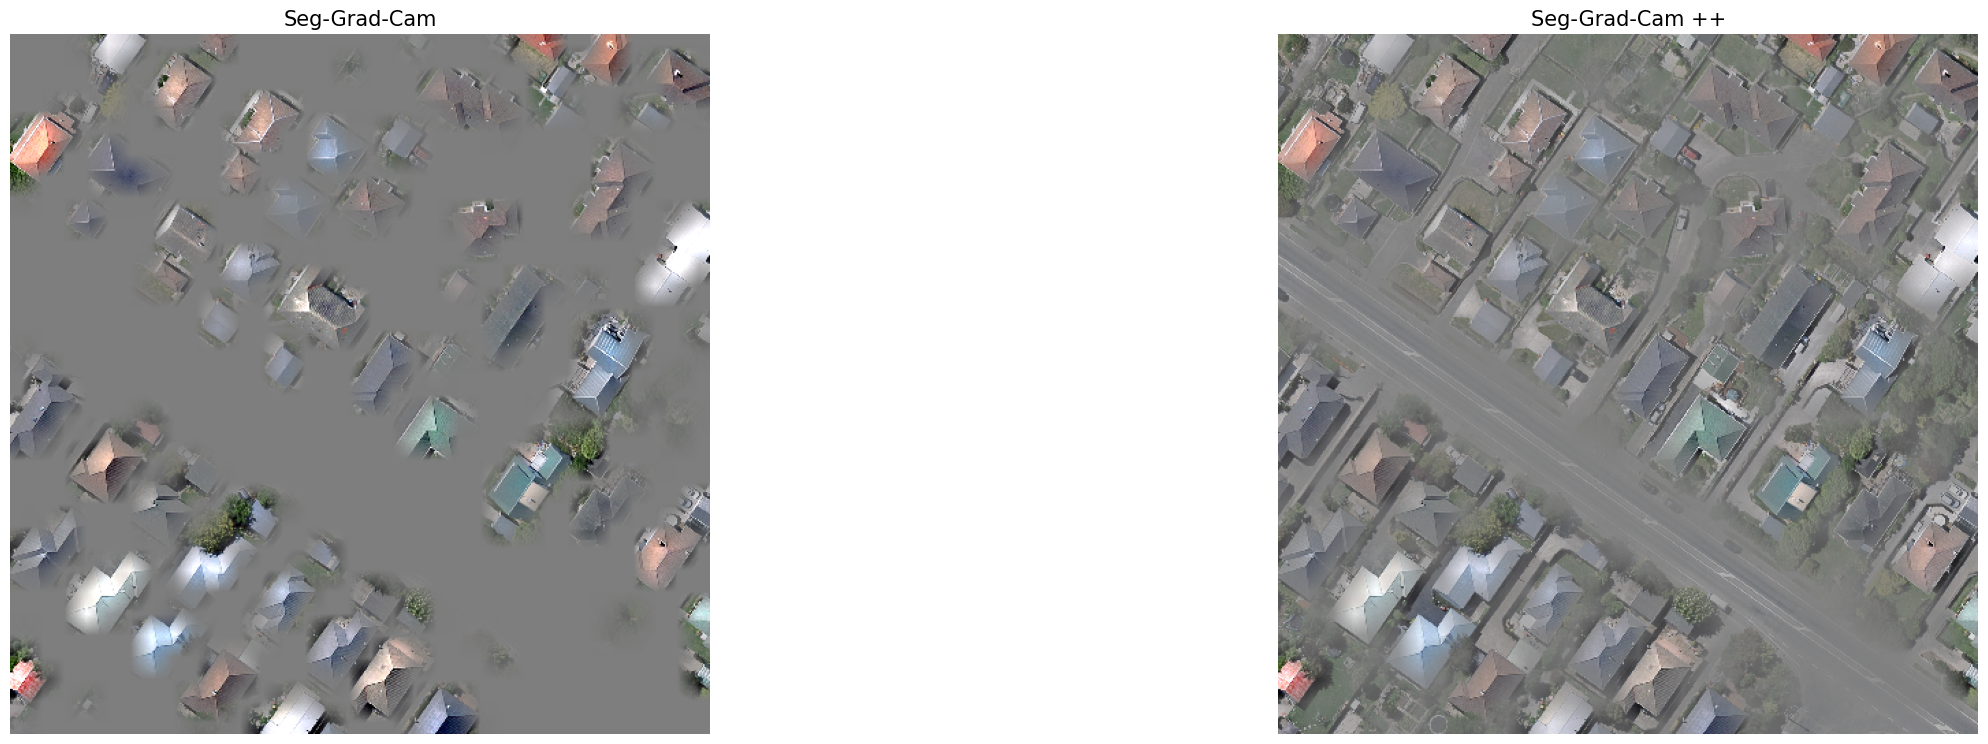

In [4]:
idxs = [1] # np.arange(0, 500)
n_imgs = len(idxs)
# SEG-GRAD-CAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM
from scipy.special import softmax

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask # .cuda()
        
    def __call__(self, model_output):
        # print('Model Output: ', model_output.shape)
        return (model_output[self.category, :, : ] * self.mask).sum()



def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img * 255)


def defaultScales():
    classes_cmap = plt.get_cmap('Spectral', 20)
    scale_fig = 2
    fonts = 15
    scatter_size = 330 * scale_fig
    return classes_cmap, scale_fig, fonts, scatter_size

# ticks = np.linspace(0, 1, 6, endpoint=True)

# classes_cmap, scale_fig, fonts, scatter_size = defaultScales()

# plt.figure(figsize=(15 * scale_fig, 10 * scale_fig))



target_class = 'road'
classid = 0 # road: 7, 
building_category = 0
target_layers =  [model.decoder.blocks[0]]
target_layers_all = [model.decoder.blocks[0], model.decoder.blocks[1] , model.decoder.blocks[2], model.decoder.blocks[3], model.decoder.blocks[4]]

print('XAI Methods for Target Class: ', target_class, "... \n\n")

number_testing_images = 0
seg_list=[]

for i,idx in enumerate(idxs):
    print("Testing Image: ", i)
    Img,tar,p_image,p_target = dataset_test.__getitem__(idx) # im,mask_gt
    
    ticks = np.linspace(0, 1, 6, endpoint=True)

    classes_cmap, scale_fig, fonts, scatter_size = defaultScales()

    plt.figure(figsize=(15 * scale_fig, 10 * scale_fig))



    if p_image.endswith('.png'):
        print(p_image)
        image = cv2.imread(p_image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        target = cv2.imread(p_target, cv2.IMREAD_UNCHANGED)
        
        if 1:
            number_testing_images = number_testing_images + 1
            
            # add weather augmentation
            image_weather = image
            target_weather = target
            with torch.inference_mode():
                model_input = transform_full(image = image_weather)["image"]
                model_input = torch.from_numpy(model_input).unsqueeze(0)
                model_input -= (0.5 * 255.0)
                model_input /= (0.5 * 255.0)
                model_input = model_input.to(S_DEVICE)
                
                logits = model(model_input) # 1,3,512,512
                logits = logits[:,0:1,:,:]
                prediction = (torch.where(logits > 0.5 , torch.tensor(1).to(S_DEVICE), torch.tensor(0).to(S_DEVICE))).to(torch.float32)
                prediction = prediction[0,0].cpu().detach().numpy()
                building_mask_float = prediction
                # print("car_mask_float info:", car_mask_float.shape, car_mask_float.dtype, car_mask_float.max())
                
            targets = [SemanticSegmentationTarget(building_category, building_mask_float)]
                        
            # Seg-Grad-CAM (Original)
            # print('Running: Seg-Grad-Cam ...')

            with GRADCAMEXTENDED(model=model, target_layers=target_layers, use_cuda= False) as cam: # 
                grayscale_cam_EX = cam(input_tensor=model_input, targets=targets)[0, :]
                # print("grayscale_cam_EX", grayscale_cam_EX.shape)
                # print(rgb_img.shape)
                # print(grayscale_cam_EX.shape)
                # seg_grad_cam_original = show_cam_on_image(rgb_img, grayscale_cam_EX, use_rgb=True)
                
            # Seg-Grad-CAM ++ (Original)
            # print('Running: Seg-Grad-Cam++ ...')
            with GRADCAMEXTENDED_Plusplus(model=model, target_layers=target_layers, use_cuda=False) as cam:
                grayscale_cam_EX_Plusplus = cam(input_tensor=model_input, targets=targets)[0, :]
                # Plusplus_seg_grad_cam_original = show_cam_on_image(rgb_img, grayscale_cam_EX_Plusplus, use_rgb=True)
                

            # Apply the cam perturbation
            E_seg_grad_cam = model_input * grayscale_cam_EX
            E_seg_grad_cam_plusPlus = model_input * grayscale_cam_EX_Plusplus
           
            # U-noise testing goes here.....



            # Save results...
            E_cam = deprocess_image(E_seg_grad_cam[0].cpu().numpy().transpose((1, 2, 0)))
            E_cam_pp = deprocess_image(E_seg_grad_cam_plusPlus[0].cpu().numpy().transpose((1, 2, 0)))
            cam_path = "./saved_images/E_cam.png"
            cam_pp_path = "./saved_images/E_cam_pp.png"
            # plt.imshow(E_cam)
            # plt.savefig(cam_path,dpi = 200,facecolor='white', transparent=False,bbox_inches='tight')
            # plt.show()
            # plt.close()
            # plt.imshow(E_cam_pp)
            # plt.savefig(cam_pp_path,dpi = 200,facecolor='white', transparent=False,bbox_inches='tight')
            # plt.show()
            # plt.close()
            
            plt.subplot(221)
            plt.axis('off')
            plt.imshow(E_cam, vmin=0, vmax=1, cmap=None)
            plt.title('Seg-Grad-Cam', fontsize=fonts)
            
            plt.subplot(222)
            plt.axis('off')
            plt.imshow(E_cam_pp, cmap='jet')
            plt.title('Seg-Grad-Cam ++', fontsize=fonts)
            plt.show()
            
            # plt.subplot(223)
            # plt.axis('off')
            # plt.imshow(E_cam_Noise_Mask, cmap='jet')
            # plt.title('Seg-Grad-Cam (Noise Mask)', fontsize=fonts)
            
            # plt.subplot(224)
            # plt.axis('off')
            # plt.imshow(E_cam_pp_Noise_Mask, cmap='jet')
            # plt.title('Seg-Grad-Cam ++ (Noise Mask)', fontsize=fonts)

#save Cam/Cam++ OG/deprocessed in a list
seg_list=[E_seg_grad_cam,E_seg_grad_cam_plusPlus,torch.tensor(E_cam).permute(2,0,1).unsqueeze(0).to(torch.float32)/255.0 , torch.tensor(E_cam_pp).permute(2,0,1).unsqueeze(0).to(torch.float32)/255.0]








length of images:  2416
length of masks:  2416


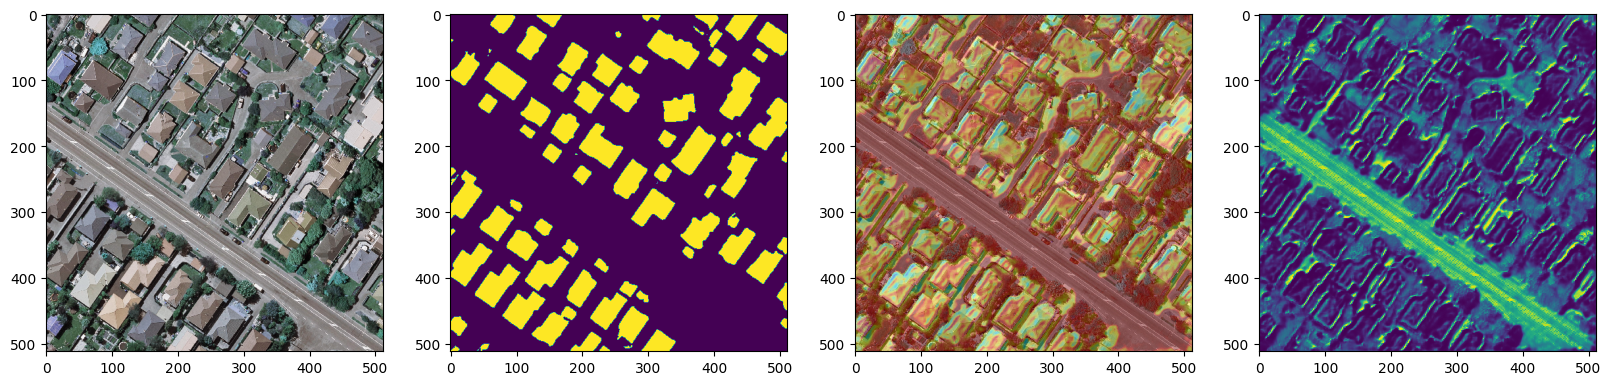

In [7]:
import albumentations as A
import cv2
import glob
import numpy as np
import torch
import os
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from tqdm import tqdm
from dataset_cityscapes import *
import matplotlib.pyplot as plt
from PIL import Image

import torch
import argparse
import os
import cv2


from segmentation_models_pytorch import Unet

from skimage.io import imread,imsave
import numpy as np
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import imageio

from utils import *
from rasterio.features import shapes
from tqdm.notebook import tqdm


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype("float32")

idxs = [1] # np.arange(0, 500)


# ======== CONFIGURATION ======== #
S_NAME_ENCODER = "efficientnet-b4"
S_NAME_WEIGHTS = "imagenet"
P_DIR_MODEL_NOISE = "/home/jamada/jupyterlab/eo-xai/whu_noise_training/UNET_EfficientNetB4_CE/Checkpoints-479/model_epoch_0030.pth"

S_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "CPU")
# S_DEVICE = 'cpu'
P_DIR_MODEL_UTIL ="/home/jamada/UrbanModels/weights_pytorch/tu-tf_efficientnet_b0_Unet_whu_3-classes_40-epochs_TRY001"

# ======== UTILITY ======== #
model = Unet(
        encoder_name = "tu-tf_efficientnet_b0",
        encoder_depth= 5,
        encoder_weights = None,
        decoder_use_batchnorm = True,
        decoder_channels = (256, 128, 64, 32, 16),
        decoder_attention_type = None,
        in_channels= 3,
        classes = 3,
        activation = 'sigmoid',
        aux_params = None,
    )

utility_model = load_model(model,P_DIR_MODEL_UTIL)
utility_model.cuda()
# ======== SETUP ======== #
# setup model
noise_model = torch.load(P_DIR_MODEL_NOISE, map_location=S_DEVICE)  
noise_model.eval()

# setup input normalization
preprocess_input = get_preprocessing_fn(
    encoder_name = S_NAME_ENCODER,
    pretrained = S_NAME_WEIGHTS,
)

transform_full = A.Compose([
    # A.Lambda(name = "image_preprocessing", image = preprocess_input),
    A.Lambda(name = "to_tensor", image = to_tensor),
])

# setup datasets
dataset_training = DataLoaderSegmentation(
    image_path = "/home/jamada/jupyterlab/datasets/WHU/WHU_building/test/images",
    mask_path = "/home/jamada/jupyterlab/datasets/WHU/WHU_building/test/masks",
    transform = transform_full,
    device = S_DEVICE
)




# plotting configuration
sz = 5
num_imgs = 4
fig,axs = plt.subplots(len(idxs),num_imgs,figsize=(sz*num_imgs,sz*len(idxs)))


j=0
for i,idx in enumerate(idxs):
    
    im,mask_gt,p_image,p_target = dataset_test.__getitem__(idx)
    image = cv2.imread(p_image)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    target = cv2.imread(p_target,cv2.IMREAD_UNCHANGED) #GT_lableIds

    # predict image 
    with torch.inference_mode():
        
        j=j+1
        im = im.unsqueeze(0)
        im = im.to(S_DEVICE)

        #########3
        im = im.to(torch.float32)
        im -= (0.5 * 255.0)
        im /= (0.5 * 255.0)
        
        
        # inference noise model
        logits = -noise_model(im)
        # print("logits shape", logits.shape)
        heatmap = logits[0,0]

        B = torch.sigmoid(noise_model(im))
        normal_distribution = torch.distributions.normal.Normal(0, 1)
        epsilon = normal_distribution.sample(B.shape).type_as(B)
        noise = epsilon * (B *5)
        noised_image = im + noise

        heatmap = torch.relu(heatmap) / heatmap.max()
        heatmap = heatmap.cpu().detach().numpy()
        resized_image = cv2.resize(image, (512,512))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap,  cv2.COLORMAP_JET)
        saliency = np.uint8(resized_image*0.6 + heatmap*0.4)
        
        #inference utility model
        with torch.no_grad():
            utility_logits = utility_model(im)
        # print("ddd",utility_logits.shape)
        utility_logits = utility_logits[:,0:1,:,:]
        # print("ddd",utility_logits.shape)
        utility_prediction = (torch.where(utility_logits > 0.5 , torch.tensor(1).to(S_DEVICE), torch.tensor(0).to(S_DEVICE))).to(torch.int)
        utility_prediction = utility_prediction[0,0].cpu().numpy()
        
        # noise_added = (torch.where(B > 0.5 , torch.tensor(1).to(S_DEVICE), torch.tensor(0).to(S_DEVICE))).to(torch.int)
        # noise_added = noise_added[0,0].cpu().numpy()
        noise_added = B[0,0].cpu().numpy()

        #resize image weather

        
        
    if axs.ndim != 1:
        axs[i,0].imshow(image)
        axs[i,1].imshow(utility_prediction)
        axs[i,2].imshow(saliency)
        axs[i,3].imshow(noise_added)
    else:
        
        axs[i].imshow(image)
        axs[i+1].imshow(utility_prediction)
        axs[i+2].imshow(saliency)
        axs[i+3].imshow(noise_added)
        plt.show()
        plt.close()
        plt.imshow(image)
        plt.savefig("./saved_images/image.png",dpi = 200,facecolor='white', transparent=False,bbox_inches='tight')
        plt.close()
        plt.imshow(utility_prediction)
        plt.savefig("./saved_images/utility_prediction.png",dpi = 200,facecolor='white', transparent=False,bbox_inches='tight')
        plt.close()
        plt.imshow(saliency)
        plt.savefig("./saved_images/saliency.png",dpi = 200,facecolor='white', transparent=False,bbox_inches='tight')
        plt.close()
        plt.imshow(noise_added)
        plt.savefig("./saved_images/noise_added.png",dpi = 200,facecolor='white', transparent=False,bbox_inches='tight')
        plt.close()
        

    
    cols = ['Original Image','Utility_Prediction', 'Saliency', 'added_noise']
if axs.ndim != 1:  
    for ax, col in zip(axs[0], cols):
        ax.set_title(col,size=10)
else:
    for ax, col in zip(axs, cols):
        ax.set_title(col,size=10)    
plt.show()

torch.float32 tensor(-0.5616) tensor(0.9059)
----> (512, 512, 3) 0 255
E_seg_grad_cam_noised


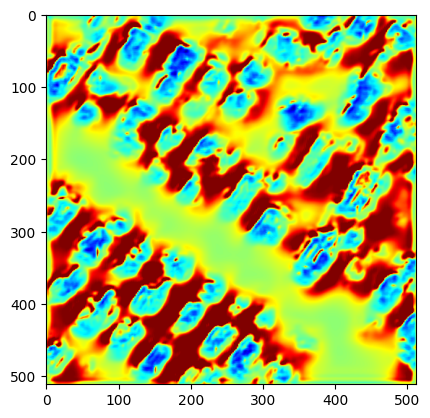

torch.float32 tensor(-0.5932) tensor(0.9059)
----> (512, 512, 3) 0 255
E_seg_grad_cam_plusPlus_noised


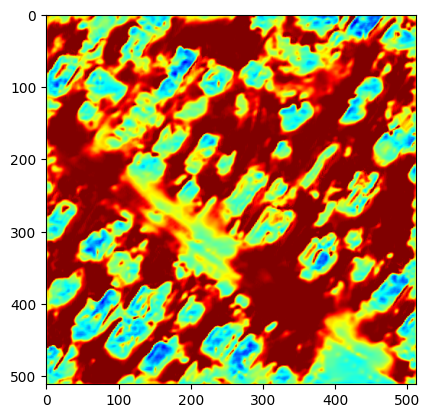

torch.float32 tensor(0.) tensor(1.)
----> (512, 512, 3) 0 255
E_cam_noised


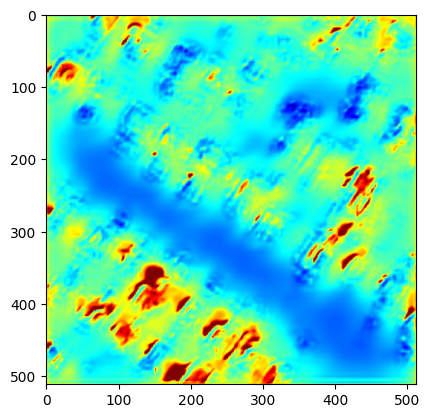

torch.float32 tensor(0.) tensor(1.)
----> (512, 512, 3) 0 255
E_cam_pp_noised


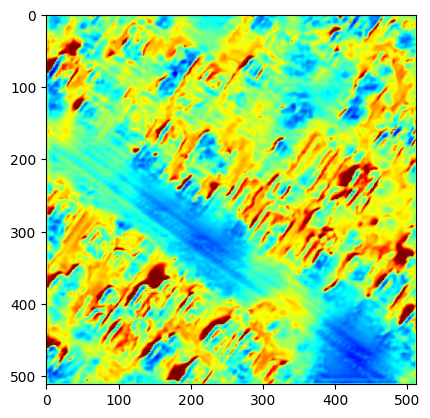

In [6]:

k=0
for imgg in seg_list:
    print(imgg.dtype, imgg.min(), imgg.max())
    logits = -noise_model(imgg.cuda())
    heatmap = logits[0,0]
    heatmap = torch.relu(heatmap) / heatmap.max()
    heatmap = heatmap.cpu().detach().numpy()
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap,  cv2.COLORMAP_JET)
    imgg = np.squeeze(imgg)
    imgg=np.transpose(imgg,(1,2,0))
    saliency = np.uint8(imgg*0.6 + heatmap*0.4)
    plt.close()
    plt.imshow(heatmap)
    print("---->", heatmap.shape ,heatmap.min(),heatmap.max())
    directory="./saved_images/"
    if k ==0 :
        print("E_seg_grad_cam_noised")
        plt.savefig("./saved_images/E_seg_grad_cam_noised",dpi = 200,facecolor='white', transparent=False,bbox_inches='tight')
    if k==1:
        print("E_seg_grad_cam_plusPlus_noised")
        plt.savefig("./saved_images/E_seg_grad_cam_plusPlus_noised",dpi = 200,facecolor='white', transparent=False,bbox_inches='tight')
    if k==2:
        print("E_cam_noised")
        plt.savefig("./saved_images/e_cam_noised",dpi = 200,facecolor='white', transparent=False,bbox_inches='tight')
    if k==3:
        print("E_cam_pp_noised")
        plt.savefig("./saved_images/E_cam_pp_noised",dpi = 200,facecolor='white', transparent=False,bbox_inches='tight')
    plt.show()
    k=k+1
